In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model, build_classifier
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%load_ext autoreload
%autoreload 2

2024-05-07 22:05:35.623980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
root = './presentation/results/zero/2024-04-24_16-13-23/'
adam_op = Adam(1e-5, 
               beta_1=0.9, 
               beta_2=0.98, 
               clipvalue=1e-4,
               epsilon=1e-9)
astromer, config = load_pt_model(os.path.join(root, 'pretraining'), optimizer=adam_op)

pd.DataFrame([config])[['data', 'arch', 'lr', 'probed', 'rs', 'same', 'mask_format', 'm_alpha']]

2024-05-07 22:05:38.038309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:05:38.041268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:05:38.041570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:05:38.043539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


e NUMA node, so returning NUMA node zero
2024-05-07 22:05:38.560252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:05:38.560611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:05:38.560906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-07 22:05:38.561191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22329 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:c2:00.0, compute capability: 8.6
2024

[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


,data,arch,lr,probed,rs,same,mask_format,m_alpha
0,./data/records/macho/,zero,0.001,0.5,0.2,0.2,QK,1.0


In [4]:
# import glob
# data_path = glob.glob(os.path.join('./data/records/atlas', '*', '*'))
# for d in data_path:
#     old = os.path.join(d, 'val')
#     new = os.path.join(d, 'validation')
#     os.rename(old, new)

## Loading downstream data

In [5]:
data_path = './data/records/atlas/fold_0/atlas_500/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=1024,
                       clf_mode=False,
                       sampling=False,
                       normalize='zero-mean',
                       old_version=False,
                       return_test=True)

[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero


In [6]:
test_loss, test_r2, test_rmse = astromer.evaluate(loaders['test'].take(10))

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['mask_out'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
      1/Unknown - 2s 2s/step - loss: 0.1702 - r_square: 0.8336 - rmse: 0.1702

2024-05-07 22:05:52.432962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4/4 [==============================] - 3s 199ms/step - loss: 0.1677 - r_square: 0.8328 - rmse: 0.1677


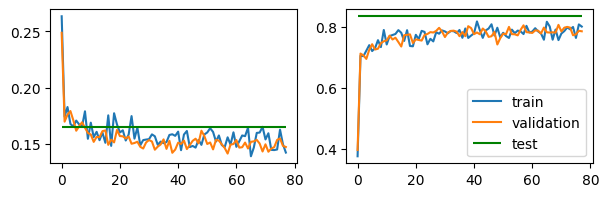

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2))
for sset in ['train', 'validation']:
    m = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', sset)) 
    axes[0].plot(m['step'], m['value'])
    m = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', sset), metric_name='epoch_r_square') 
    axes[1].plot(m['step'], m['value'], label=sset)

axes[0].hlines(test_loss, 0, m['step'].max(), color='g', label='test')
axes[1].hlines(test_r2, 0, m['step'].max(), color='g', label='test')
plt.legend()
plt.show()

## Finetuning

In [8]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [9]:
from src.training.utils import train
import shutil

In [12]:
TARGET = './presentation/results/test'
os.makedirs(TARGET)
shutil.copyfile(os.path.join(root, 'pretraining', 'config.toml'), 
                os.path.join(TARGET, 'config.toml'))

'./presentation/results/test/config.toml'

In [13]:
cbks = [EarlyStopping(monitor='val_loss', patience=20),
        ModelCheckpoint(filepath=os.path.join(TARGET, 'weights'),
                        save_weights_only=True,
                        save_best_only=True,
                        save_freq='epoch',
                        verbose=1)]
    
# Finetune model
hist = astromer.fit(loaders['train'], 
                        batch_size=1024,
                        epochs=10000, 
                        validation_data=loaders['validation'],
                        callbacks=cbks)
        
# astromer = train(astromer, 
#                  loaders['train'], 
#                  loaders['validation'], 
#                  exp_path=TARGET,
#                  epochs=10000)

Epoch 1/10000
      3/Unknown - 1s 202ms/step - loss: 0.1424 - r_square: 0.8544 - rmse: 0.1424
Epoch 1: val_loss improved from inf to 0.12841, saving model to ./presentation/results/test/weights
4/4 [==============================] - 2s 364ms/step - loss: 0.1376 - r_square: 0.8471 - rmse: 0.1376 - val_loss: 0.1284 - val_r_square: 0.8905 - val_rmse: 0.1284
Epoch 2/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.1358 - r_square: 0.8949 - rmse: 0.1358
Epoch 2: val_loss improved from 0.12841 to 0.12536, saving model to ./presentation/results/test/weights
4/4 [==============================] - 1s 324ms/step - loss: 0.1351 - r_square: 0.8959 - rmse: 0.1351 - val_loss: 0.1254 - val_r_square: 0.8937 - val_rmse: 0.1254
Epoch 3/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.1249 - r_square: 0.8958 - rmse: 0.1249
Epoch 3: val_loss improved from 0.12536 to 0.12038, saving model to ./presentation/results/test/weights
4/4 [==============================] - 1s 323ms/ste

Epoch 24/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0897 - r_square: 0.9455 - rmse: 0.0897
Epoch 24: val_loss did not improve from 0.08980
4/4 [==============================] - 1s 296ms/step - loss: 0.0884 - r_square: 0.9445 - rmse: 0.0884 - val_loss: 0.0931 - val_r_square: 0.9393 - val_rmse: 0.0931
Epoch 25/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0889 - r_square: 0.9514 - rmse: 0.0889
Epoch 25: val_loss did not improve from 0.08980
4/4 [==============================] - 1s 299ms/step - loss: 0.0868 - r_square: 0.9535 - rmse: 0.0868 - val_loss: 0.0900 - val_r_square: 0.9432 - val_rmse: 0.0900
Epoch 26/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0897 - r_square: 0.9507 - rmse: 0.0897
Epoch 26: val_loss did not improve from 0.08980
4/4 [==============================] - 1s 290ms/step - loss: 0.0895 - r_square: 0.9515 - rmse: 0.0895 - val_loss: 0.0926 - val_r_square: 0.9404 - val_rmse: 0.0926
Epoch 27/10000
3/4 [==============

Epoch 49/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0898 - r_square: 0.9583 - rmse: 0.0898
Epoch 49: val_loss did not improve from 0.08475
4/4 [==============================] - 1s 305ms/step - loss: 0.0926 - r_square: 0.9598 - rmse: 0.0926 - val_loss: 0.0861 - val_r_square: 0.9477 - val_rmse: 0.0861
Epoch 50/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0873 - r_square: 0.9424 - rmse: 0.0873
Epoch 50: val_loss did not improve from 0.08475
4/4 [==============================] - 1s 300ms/step - loss: 0.0879 - r_square: 0.9363 - rmse: 0.0879 - val_loss: 0.0883 - val_r_square: 0.9455 - val_rmse: 0.0883
Epoch 51/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0816 - r_square: 0.9566 - rmse: 0.0816
Epoch 51: val_loss did not improve from 0.08475
4/4 [==============================] - 1s 302ms/step - loss: 0.0814 - r_square: 0.9562 - rmse: 0.0814 - val_loss: 0.0885 - val_r_square: 0.9458 - val_rmse: 0.0885
Epoch 52/10000
3/4 [==============

Epoch 74/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0810 - r_square: 0.9655 - rmse: 0.0810
Epoch 74: val_loss did not improve from 0.07895
4/4 [==============================] - 1s 306ms/step - loss: 0.0814 - r_square: 0.9690 - rmse: 0.0814 - val_loss: 0.0814 - val_r_square: 0.9527 - val_rmse: 0.0814
Epoch 75/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0833 - r_square: 0.9580 - rmse: 0.0833
Epoch 75: val_loss did not improve from 0.07895
4/4 [==============================] - 1s 297ms/step - loss: 0.0845 - r_square: 0.9576 - rmse: 0.0845 - val_loss: 0.0872 - val_r_square: 0.9467 - val_rmse: 0.0872
Epoch 76/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0820 - r_square: 0.9601 - rmse: 0.0820
Epoch 76: val_loss did not improve from 0.07895
4/4 [==============================] - 1s 311ms/step - loss: 0.0829 - r_square: 0.9609 - rmse: 0.0829 - val_loss: 0.0870 - val_r_square: 0.9482 - val_rmse: 0.0870
Epoch 77/10000
3/4 [==============

Epoch 99/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0803 - r_square: 0.9584 - rmse: 0.0803
Epoch 99: val_loss did not improve from 0.07735
4/4 [==============================] - 1s 311ms/step - loss: 0.0799 - r_square: 0.9581 - rmse: 0.0799 - val_loss: 0.0783 - val_r_square: 0.9566 - val_rmse: 0.0783
Epoch 100/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0790 - r_square: 0.9604 - rmse: 0.0790
Epoch 100: val_loss improved from 0.07735 to 0.07676, saving model to ./presentation/results/test/weights
4/4 [==============================] - 2s 343ms/step - loss: 0.0782 - r_square: 0.9615 - rmse: 0.0782 - val_loss: 0.0768 - val_r_square: 0.9579 - val_rmse: 0.0768
Epoch 101/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0797 - r_square: 0.9608 - rmse: 0.0797
Epoch 101: val_loss did not improve from 0.07676
4/4 [==============================] - 1s 300ms/step - loss: 0.0805 - r_square: 0.9607 - rmse: 0.0805 - val_loss: 0.0783 - val_r_square:

Epoch 124/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0802 - r_square: 0.9541 - rmse: 0.0802
Epoch 124: val_loss did not improve from 0.07560
4/4 [==============================] - 1s 302ms/step - loss: 0.0798 - r_square: 0.9516 - rmse: 0.0798 - val_loss: 0.0785 - val_r_square: 0.9561 - val_rmse: 0.0785
Epoch 125/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0807 - r_square: 0.9609 - rmse: 0.0807
Epoch 125: val_loss did not improve from 0.07560
4/4 [==============================] - 1s 294ms/step - loss: 0.0797 - r_square: 0.9624 - rmse: 0.0797 - val_loss: 0.0797 - val_r_square: 0.9542 - val_rmse: 0.0797
Epoch 126/10000
3/4 [=====================>........] - ETA: 0s - loss: 0.0838 - r_square: 0.9629 - rmse: 0.0838
Epoch 126: val_loss did not improve from 0.07560
4/4 [==============================] - 1s 303ms/step - loss: 0.0858 - r_square: 0.9642 - rmse: 0.0858 - val_loss: 0.0762 - val_r_square: 0.9579 - val_rmse: 0.0762
Epoch 127/10000
3/4 [=======

In [14]:
test_loss, test_r2, test_rmse = astromer.evaluate(loaders['test'].take(10))

4/4 [==============================] - 1s 103ms/step - loss: 0.0828 - r_square: 0.9516 - rmse: 0.0828


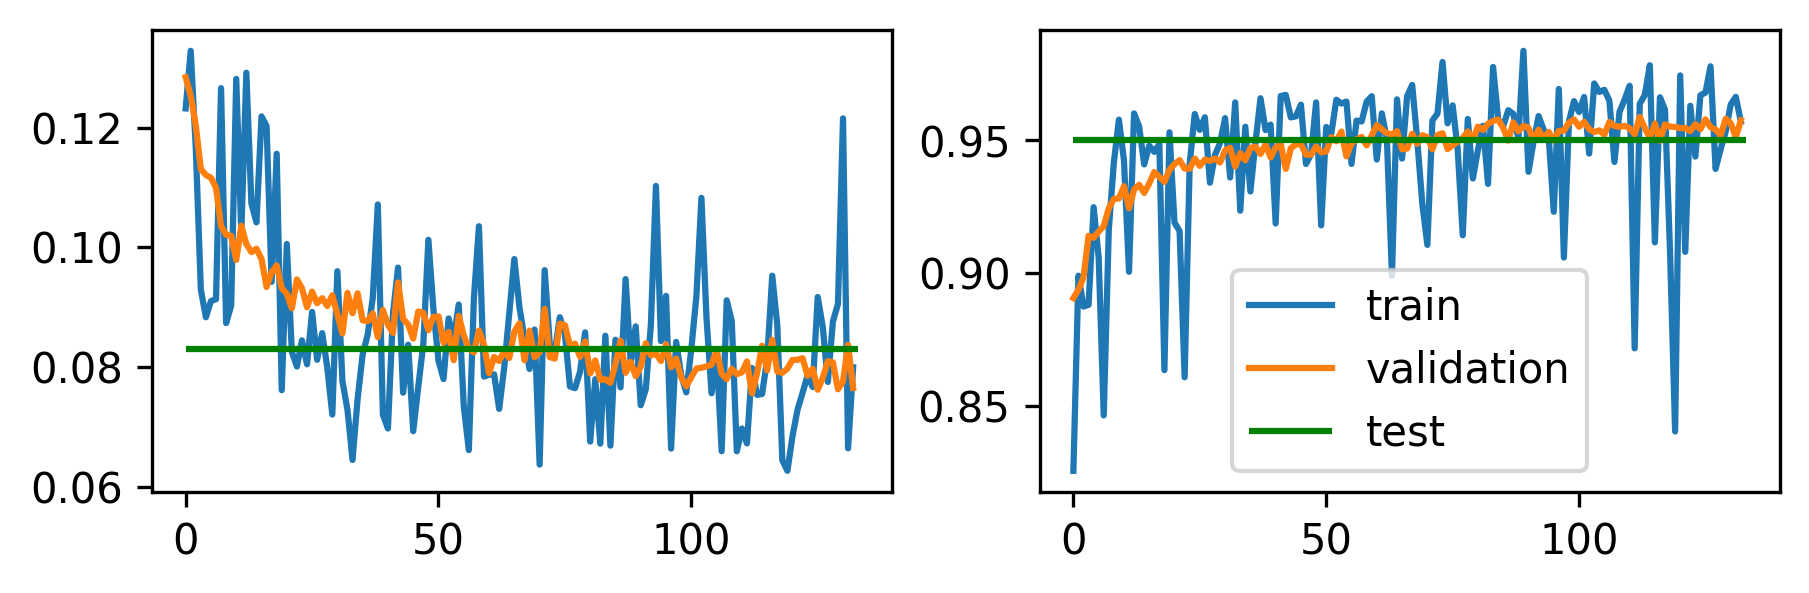

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2), dpi=300)
axes[0].plot(hist.history['loss'], label='train')
axes[0].plot(hist.history['val_loss'], label='validation')
axes[1].plot(hist.history['r_square'], label='train')
axes[1].plot(hist.history['val_r_square'], label='validation')
    
axes[0].hlines(test_loss, 0, len(hist.history['loss']), color='g', label='test')
axes[1].hlines(test_r2, 0, len(hist.history['loss']), color='g', label='test')
axes[-1].legend()
plt.show()

## Classification

In [4]:
from presentation.pipelines.steps.utils import train_classifier, predict_clf

In [27]:
data_path = './data/records/atlas/fold_0/atlas_500/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=1024,
                       clf_mode=True,
                       sampling=False,
                       normalize='zero-mean',
                       old_version=True,
                       return_test=True)

Classification Mode
[INFO] Probed: 1.00 Random: 0.00 Same: 0.00
[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Zero


In [29]:
# for x, y in loaders['train'].take(1):
#     print(x['mask_in'])

In [6]:
adam_op = Adam(1e-3, 
               beta_1=0.9, 
               beta_2=0.98, 
               epsilon=1e-9)

astromer, config = load_pt_model('./presentation/results/test/', optimizer=adam_op)

[INFO] Zero architecture loaded
[INFO] Using masked-att with alpha = 1.00
[INFO] Using masked-att with alpha = 1.00
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens


In [7]:
clf = build_classifier(astromer, 
                         config, 
                         astromer_trainable=False, 
                         num_cls=loaders['n_classes'], 
                         arch='avg_mlp')

[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
[INFO] Using avg_mlp clf architecture with zero


In [11]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop

In [15]:
target_dir = os.path.join('./presentation/results/test')
optimizer = Adam(learning_rate=1e-3)
os.makedirs(target_dir, exist_ok=True)

clf.compile(optimizer=optimizer,
              loss=CategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

estop = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=20,
                      verbose=0,
                      mode='auto',
                      baseline=None,
                      restore_best_weights=True)
tb = TensorBoard(log_dir=os.path.join(target_dir, 'logs'),
                 write_graph=False,
                 write_images=False,
                 update_freq='epoch',
                 profile_batch=0,
                 embeddings_freq=0,
                 embeddings_metadata=None)

hist = clf.fit(loaders['train'],
              epochs=10000,
              batch_size=512,
              callbacks=[estop, tb],
              validation_data=loaders['validation'])

Epoch 1/10000
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['mask_out'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[INFO] Masking Query and Key tokens
[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
      3/Unknown - 4s 116ms/step - loss: 1.4337 - accuracy: 0.4444[INFO] Using PE with c: 2.0
[INFO] Masking Query and Key tokens
[INFO] Masking Query and Key tokens
3/3 [==============================] - 5s 683ms/step - loss: 1.4337 - accuracy: 0.4444 - val_loss: 1.0647 - val_accuracy: 0.4584
Epoch 2/10000
3/3 [==============================] - 1s 386ms/step - loss: 1.2456 - accuracy: 0.4084 - val_loss: 1.0915 - val_accuracy: 0.4932
Epoch 3/10000
3/3 [==============================] - 1s 373ms/step - loss: 1.1087 - accuracy: 0.4871 - val_loss: 1.1699 - val_accuracy: 0.4081
Epoch 4/10000
3/3 [==============================] - 1s 361ms/step - loss: 1.2096 - accuracy: 0.4065 - val_loss: 1.1302 - val_accuracy: 0.4120
Epoch 5/10000
3/3 [==============================] - 1s 390ms/step - loss: 1.1515 - accuracy: 0.4099 - val_loss: 1.0980 - val_accuracy: 0.406

Epoch 56/10000
3/3 [==============================] - 1s 373ms/step - loss: 1.0298 - accuracy: 0.5403 - val_loss: 0.9752 - val_accuracy: 0.5667
Epoch 57/10000
3/3 [==============================] - 1s 375ms/step - loss: 1.0117 - accuracy: 0.5532 - val_loss: 1.0248 - val_accuracy: 0.5455
Epoch 58/10000
3/3 [==============================] - 1s 369ms/step - loss: 1.0592 - accuracy: 0.5235 - val_loss: 0.9755 - val_accuracy: 0.5377
Epoch 59/10000
3/3 [==============================] - 1s 384ms/step - loss: 0.9941 - accuracy: 0.5441 - val_loss: 1.0034 - val_accuracy: 0.5280
Epoch 60/10000
3/3 [==============================] - 1s 345ms/step - loss: 1.0183 - accuracy: 0.5398 - val_loss: 1.0390 - val_accuracy: 0.5261
Epoch 61/10000
3/3 [==============================] - 1s 383ms/step - loss: 1.0793 - accuracy: 0.5005 - val_loss: 0.9390 - val_accuracy: 0.5822
Epoch 62/10000
3/3 [==============================] - 1s 382ms/step - loss: 1.0139 - accuracy: 0.5398 - val_loss: 0.9359 - val_accuracy:

Epoch 113/10000
3/3 [==============================] - 1s 383ms/step - loss: 1.0286 - accuracy: 0.5312 - val_loss: 1.0433 - val_accuracy: 0.5358
Epoch 114/10000
3/3 [==============================] - 1s 386ms/step - loss: 1.0466 - accuracy: 0.5427 - val_loss: 0.9099 - val_accuracy: 0.6190
Epoch 115/10000
3/3 [==============================] - 1s 399ms/step - loss: 0.9283 - accuracy: 0.5810 - val_loss: 0.9009 - val_accuracy: 0.6286
Epoch 116/10000
3/3 [==============================] - 1s 383ms/step - loss: 0.9217 - accuracy: 0.5964 - val_loss: 0.9013 - val_accuracy: 0.5957
Epoch 117/10000
3/3 [==============================] - 1s 383ms/step - loss: 0.9094 - accuracy: 0.5944 - val_loss: 0.8865 - val_accuracy: 0.6151
Epoch 118/10000
3/3 [==============================] - 1s 395ms/step - loss: 0.8921 - accuracy: 0.6012 - val_loss: 0.8675 - val_accuracy: 0.6538
Epoch 119/10000
3/3 [==============================] - 1s 374ms/step - loss: 0.8854 - accuracy: 0.6290 - val_loss: 0.8822 - val_ac

In [22]:
scores = predict_clf(clf, loaders['test'])

test: 3it [00:01,  2.63it/s]


In [25]:
'{:.2f}'.format(scores['f1'])

'0.64'